# 1.14c: Velocity Autocorrelation

**Goal:** Distinguish ballistic motion from diffusive motion by measuring velocity autocorrelation.

## What is Autocorrelation?

Autocorrelation measures how similar a signal is to a time-shifted copy of itself. For velocity, it tells us:

$$C(\tau) = \langle \mathbf{v}(t) \cdot \mathbf{v}(t+\tau) \rangle$$

Where:
- $\mathbf{v}(t) = \mathbf{W}(t+1) - \mathbf{W}(t)$ is velocity at time $t$
- $\tau$ is the time lag
- $\langle \cdot \rangle$ means average over all tokens and all times

**Interpretation:**
- $C(0)$ = mean squared speed (always positive)
- $C(\tau) \approx C(0)$ for large $\tau$ → **ballistic** (constant velocity, no random changes)
- $C(\tau) \to 0$ quickly → **diffusive** (random walk, velocity decorrelates fast)

## Physical Intuition

Think of a token's trajectory as a series of steps:

**Ballistic motion** (e.g., a thrown ball):
- Velocity stays roughly constant over many steps
- $\mathbf{v}(t) \approx \mathbf{v}(t+1) \approx \mathbf{v}(t+2) \approx \ldots$
- Dot product $\mathbf{v}(t) \cdot \mathbf{v}(t+\tau)$ stays large
- Autocorrelation decays **slowly**

**Diffusive motion** (e.g., Brownian motion):
- Velocity changes randomly each step
- $\mathbf{v}(t)$ has no relation to $\mathbf{v}(t+\tau)$ for $\tau > 0$
- Dot product averages to zero
- Autocorrelation decays **fast** (within 1-2 steps)

## What We'll Measure

For trained tokens only (untrained tokens are frozen in black hole):
1. Compute velocity at each timestep: $\mathbf{v}(t) = \mathbf{W}(t+1) - \mathbf{W}(t)$
2. For each lag $\tau$, compute $C(\tau) = \langle \mathbf{v}(t) \cdot \mathbf{v}(t+\tau) \rangle$
3. Normalize: $\rho(\tau) = C(\tau) / C(0)$ (correlation coefficient, range [0,1])
4. Plot $\rho(\tau)$ vs $\tau$ to see how fast correlation decays

## Expected Results

From the 1.14a plot, we see:
- **Early steps (0-50):** Straight-line escape → probably **ballistic**
- **Middle steps (50-400):** Turbulent realm → probably **diffusive** or mixed
- **Late steps (400+):** Settling → low velocity overall

We expect:
- $\rho(\tau)$ starts near 1.0 for small $\tau$ (velocities are correlated)
- Decays to ~0 as $\tau$ increases (eventually no correlation)
- **Fast decay** (within 1-10 steps) → diffusive
- **Slow decay** (50+ steps) → ballistic

## Note on Adam Momentum

Adam optimizer maintains momentum (exponential moving average of past gradients). This acts like **inertia**—tokens keep moving in the direction they were moving even if gradients change. This could create ballistic-like motion even in a noisy gradient field. Worth keeping in mind when interpreting results.

## Parameters

In [1]:
# Training data to analyze
TRAINING_DATA_PATH = "../tensors/Lil_Gatsby/1.12a_training_data_default_init_50000.safetensors"

# Corpus path (to identify trained tokens)
CORPUS_PATH = "../data/fineweb_ascii.txt"

# Autocorrelation parameters
MAX_LAG = 100  # Maximum time lag to compute (in steps)

# Time windows to analyze separately
TIME_WINDOWS = [
    (0, 50, 'Early escape'),
    (50, 400, 'Turbulent middle'),
    (400, 2000, 'Late settling'),
    (0, 10000, 'Full trajectory'),
]

# Visualization
PLOT_DPI = 150

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from safetensors.torch import load_file

print("✓ Imports complete")

✓ Imports complete


## Load Training Data

In [3]:
print(f"Loading training data: {TRAINING_DATA_PATH}\n")

data = load_file(TRAINING_DATA_PATH)
embeddings = data['embeddings'].float()  # (n_steps, vocab_size, hidden_dim)

n_steps, vocab_size, hidden_dim = embeddings.shape

print(f"✓ Loaded training data")
print(f"  Shape: {embeddings.shape}")
print(f"  Steps: {n_steps:,}")
print(f"  Vocab: {vocab_size}")
print(f"  Hidden dim: {hidden_dim}")

Loading training data: ../tensors/Lil_Gatsby/1.12a_training_data_default_init_50000.safetensors

✓ Loaded training data
  Shape: torch.Size([50001, 128, 64])
  Steps: 50,001
  Vocab: 128
  Hidden dim: 64


## Identify Trained Tokens

In [4]:
print(f"\nAnalyzing corpus: {CORPUS_PATH}\n")

# Read corpus and find which tokens appear
with open(CORPUS_PATH, 'r', encoding='ascii') as f:
    corpus_text = f.read()

corpus_bytes = corpus_text.encode('ascii')
trained_tokens = sorted(set(corpus_bytes))
untrained_tokens = sorted(set(range(vocab_size)) - set(trained_tokens))

print(f"✓ Identified token usage")
print(f"  Trained: {len(trained_tokens)} tokens")
print(f"  Untrained: {len(untrained_tokens)} tokens")

trained_indices = torch.tensor(trained_tokens, dtype=torch.long)


Analyzing corpus: ../data/fineweb_ascii.txt

✓ Identified token usage
  Trained: 94 tokens
  Untrained: 34 tokens


## Compute Velocities

Velocity at time $t$ is the displacement from $t$ to $t+1$:

$$\mathbf{v}(t) = \mathbf{W}(t+1) - \mathbf{W}(t)$$

In [5]:
print(f"\nComputing velocities for trained tokens...\n")

# Get positions for trained tokens only
# Shape: (n_steps, n_trained, hidden_dim)
trained_positions = embeddings[:, trained_indices, :]

# Velocity = position difference between consecutive steps
# v[t] = pos[t+1] - pos[t]
# Shape: (n_steps-1, n_trained, hidden_dim)
velocities = trained_positions[1:] - trained_positions[:-1]

n_velocity_steps = velocities.shape[0]

print(f"✓ Computed velocities")
print(f"  Shape: {velocities.shape}")
print(f"  Velocity steps: {n_velocity_steps:,} (one less than position steps)")
print(f"  Tokens: {len(trained_tokens)}")
print(f"  Dimensions: {hidden_dim}")


Computing velocities for trained tokens...

✓ Computed velocities
  Shape: torch.Size([50000, 94, 64])
  Velocity steps: 50,000 (one less than position steps)
  Tokens: 94
  Dimensions: 64


## Compute Velocity Autocorrelation

For each lag $\tau$, we compute:

$$C(\tau) = \frac{1}{N(\tau)} \sum_{t=0}^{T-\tau-1} \sum_{i=1}^{N_{\text{tokens}}} \mathbf{v}_i(t) \cdot \mathbf{v}_i(t+\tau)$$

Where:
- $N(\tau) = (T-\tau) \times N_{\text{tokens}}$ is the number of samples
- We average over all tokens and all valid time windows

Then normalize by $C(0)$ to get correlation coefficient:

$$\rho(\tau) = \frac{C(\tau)}{C(0)}$$

In [6]:
def compute_autocorrelation(velocities, max_lag, time_start=0, time_end=None):
    """
    Compute velocity autocorrelation for a time window.
    
    Args:
        velocities: (n_steps, n_tokens, hidden_dim) tensor
        max_lag: maximum time lag to compute
        time_start: start of time window (inclusive)
        time_end: end of time window (exclusive), None = all
    
    Returns:
        lags: array of lag values [0, 1, 2, ..., max_lag]
        autocorr: array of autocorrelation values C(τ)
        autocorr_normalized: array of normalized autocorr ρ(τ) = C(τ)/C(0)
    """
    if time_end is None:
        time_end = velocities.shape[0]
    
    # Extract time window
    v_window = velocities[time_start:time_end]  # (window_size, n_tokens, hidden_dim)
    window_size = v_window.shape[0]
    
    # Limit max_lag to window size
    max_lag = min(max_lag, window_size - 1)
    
    lags = np.arange(max_lag + 1)
    autocorr = np.zeros(max_lag + 1)
    
    for tau in lags:
        # For lag τ, we can use steps [0, window_size - τ - 1]
        n_samples = window_size - tau
        
        # v(t) · v(t+τ) for all t, all tokens
        # Shape: (n_samples, n_tokens, hidden_dim)
        v_t = v_window[:n_samples]
        v_t_plus_tau = v_window[tau:tau+n_samples]
        
        # Dot product along hidden_dim, then average over all samples and tokens
        dot_products = (v_t * v_t_plus_tau).sum(dim=2)  # (n_samples, n_tokens)
        autocorr[tau] = dot_products.mean().item()
    
    # Normalize by C(0)
    autocorr_normalized = autocorr / autocorr[0] if autocorr[0] > 0 else autocorr
    
    return lags, autocorr, autocorr_normalized

print("✓ Autocorrelation function defined")

✓ Autocorrelation function defined


## Compute Autocorrelation for Each Time Window

In [7]:
print(f"\nComputing autocorrelation for {len(TIME_WINDOWS)} time windows...\n")

results = {}

for t_start, t_end, label in TIME_WINDOWS:
    print(f"Window: {label} (steps {t_start}-{t_end})")
    
    # Compute autocorrelation
    lags, C_tau, rho_tau = compute_autocorrelation(
        velocities, 
        max_lag=MAX_LAG,
        time_start=t_start,
        time_end=min(t_end, n_velocity_steps)
    )
    
    # Store results
    results[label] = {
        'lags': lags,
        'C_tau': C_tau,
        'rho_tau': rho_tau,
        't_start': t_start,
        't_end': t_end,
    }
    
    # Quick stats
    print(f"  C(0) = {C_tau[0]:.6e} (mean squared speed)")
    print(f"  ρ(1) = {rho_tau[1]:.4f} (correlation at lag 1)")
    print(f"  ρ(10) = {rho_tau[10]:.4f} (correlation at lag 10)")
    if len(rho_tau) > 50:
        print(f"  ρ(50) = {rho_tau[50]:.4f} (correlation at lag 50)")
    print()

print(f"✓ Autocorrelation computed for all windows")


Computing autocorrelation for 4 time windows...

Window: Early escape (steps 0-50)
  C(0) = 2.893425e-05 (mean squared speed)
  ρ(1) = 0.9589 (correlation at lag 1)
  ρ(10) = 0.8728 (correlation at lag 10)

Window: Turbulent middle (steps 50-400)
  C(0) = 3.191576e-06 (mean squared speed)
  ρ(1) = 0.8795 (correlation at lag 1)
  ρ(10) = 0.3564 (correlation at lag 10)
  ρ(50) = 0.0947 (correlation at lag 50)

Window: Late settling (steps 400-2000)
  C(0) = 2.110857e-06 (mean squared speed)
  ρ(1) = 0.8343 (correlation at lag 1)
  ρ(10) = 0.2382 (correlation at lag 10)
  ρ(50) = -0.0254 (correlation at lag 50)

Window: Full trajectory (steps 0-10000)
  C(0) = 1.140111e-06 (mean squared speed)
  ρ(1) = 0.8336 (correlation at lag 1)
  ρ(10) = 0.3018 (correlation at lag 10)
  ρ(50) = 0.0078 (correlation at lag 50)

✓ Autocorrelation computed for all windows


## Plot: Velocity Autocorrelation


Plotting velocity autocorrelation...



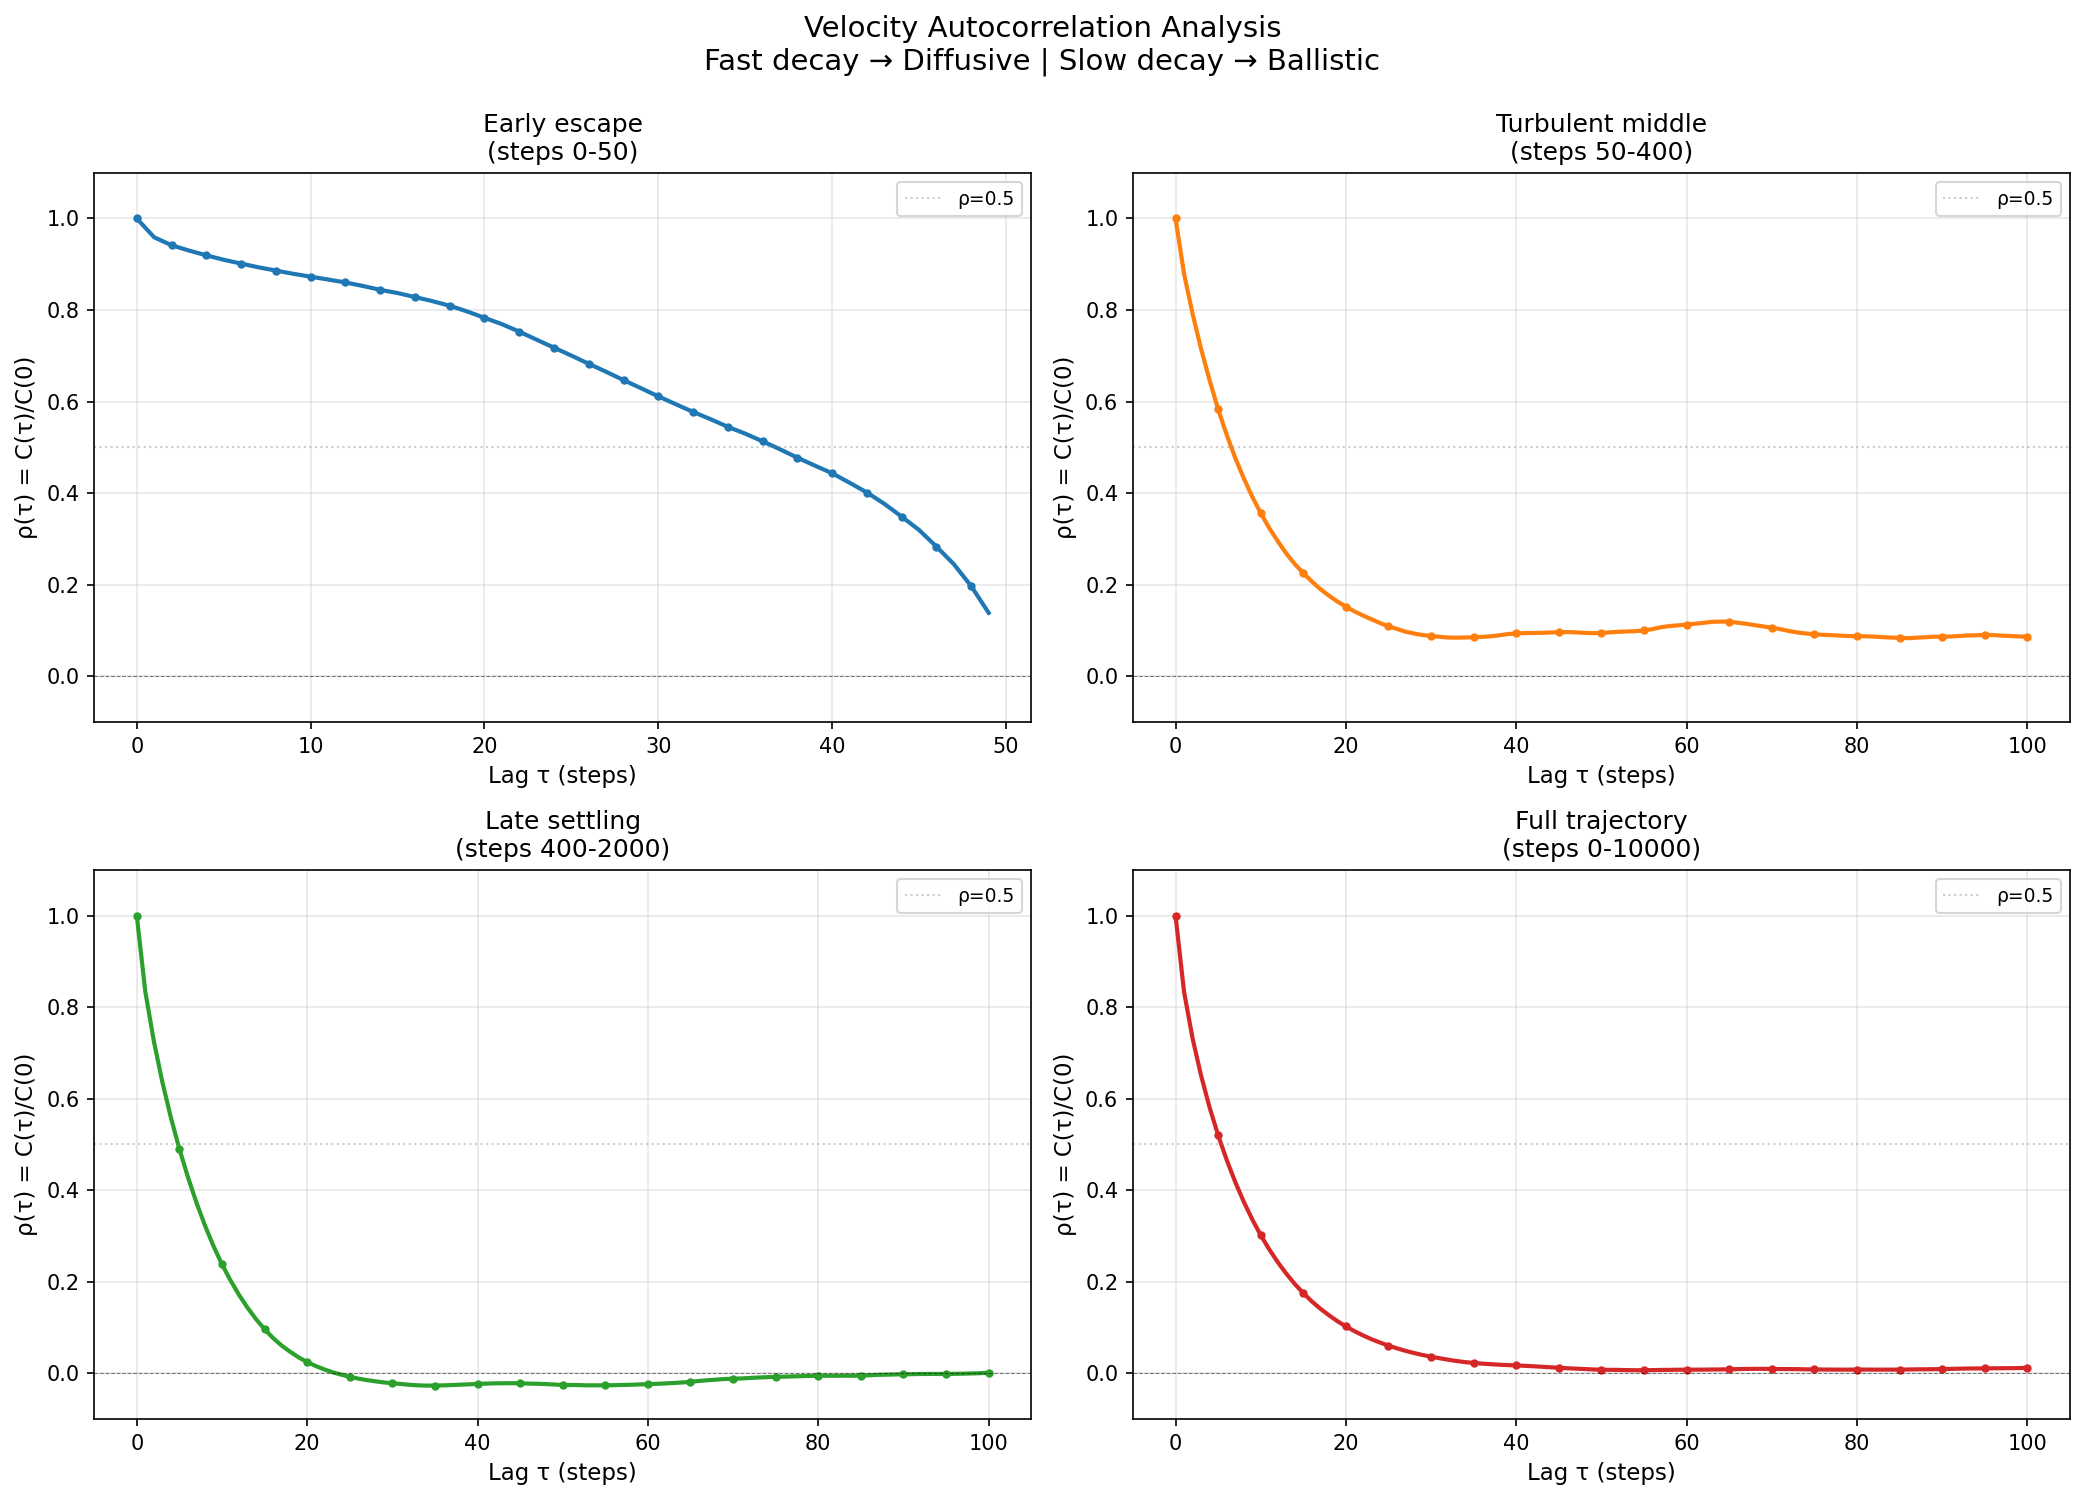

✓ Visualization complete


In [8]:
print(f"\nPlotting velocity autocorrelation...\n")

fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=PLOT_DPI)
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, (label, result) in enumerate(results.items()):
    ax = axes[idx]
    
    lags = result['lags']
    rho_tau = result['rho_tau']
    t_start = result['t_start']
    t_end = result['t_end']
    
    ax.plot(lags, rho_tau, linewidth=2, color=colors[idx], marker='o', 
            markersize=3, markevery=max(1, len(lags)//20))
    
    ax.set_xlabel('Lag τ (steps)', fontsize=11)
    ax.set_ylabel('ρ(τ) = C(τ)/C(0)', fontsize=11)
    ax.set_title(f'{label}\n(steps {t_start}-{t_end})', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.5)
    ax.set_ylim(-0.1, 1.1)
    
    # Add reference lines for ballistic vs diffusive
    ax.axhline(0.5, color='gray', linewidth=1, linestyle=':', alpha=0.4, label='ρ=0.5')
    ax.legend(loc='upper right', fontsize=9)

plt.suptitle('Velocity Autocorrelation Analysis\n' + 
             'Fast decay → Diffusive | Slow decay → Ballistic', 
             fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

print(f"✓ Visualization complete")

## Analysis: Ballistic vs Diffusive

**How to interpret the plots:**

1. **ρ(τ) ≈ 1 for large τ** → **Ballistic motion**
   - Velocity is constant over many steps
   - Token is "coasting" in a fixed direction
   - Suggests persistent gradient direction or Adam momentum

2. **ρ(τ) → 0 quickly (within 1-10 steps)** → **Diffusive motion**
   - Velocity changes randomly each step
   - No memory of previous direction
   - Suggests noisy or rapidly changing gradient field

3. **ρ(τ) decays gradually** → **Mixed regime**
   - Some persistence but not fully ballistic
   - Could be weak momentum or slowly changing gradients

**Characteristic decay time:**

Find $\tau^*$ where $\rho(\tau^*) = 0.5$ (half of initial correlation):
- $\tau^* \lesssim 1$ → purely diffusive
- $\tau^* \sim 5-10$ → weakly ballistic
- $\tau^* \gg 10$ → strongly ballistic

In [9]:
print(f"\n{'='*80}")
print(f"CHARACTERISTIC DECAY TIMES")
print(f"{'='*80}\n")

for label, result in results.items():
    rho_tau = result['rho_tau']
    lags = result['lags']
    
    # Find where ρ(τ) crosses 0.5
    try:
        tau_half = np.where(rho_tau < 0.5)[0][0]
    except IndexError:
        tau_half = len(rho_tau)  # Never decays below 0.5
    
    # Find where ρ(τ) crosses 0.1
    try:
        tau_tenth = np.where(rho_tau < 0.1)[0][0]
    except IndexError:
        tau_tenth = len(rho_tau)
    
    print(f"{label}:")
    print(f"  τ at ρ=0.5: {tau_half} steps")
    print(f"  τ at ρ=0.1: {tau_tenth} steps")
    
    if tau_half <= 1:
        regime = "STRONGLY DIFFUSIVE"
    elif tau_half <= 5:
        regime = "DIFFUSIVE"
    elif tau_half <= 10:
        regime = "WEAKLY BALLISTIC"
    elif tau_half <= 50:
        regime = "BALLISTIC"
    else:
        regime = "STRONGLY BALLISTIC"
    
    print(f"  Regime: {regime}")
    print()

print(f"{'='*80}")


CHARACTERISTIC DECAY TIMES

Early escape:
  τ at ρ=0.5: 37 steps
  τ at ρ=0.1: 50 steps
  Regime: BALLISTIC

Turbulent middle:
  τ at ρ=0.5: 7 steps
  τ at ρ=0.1: 27 steps
  Regime: WEAKLY BALLISTIC

Late settling:
  τ at ρ=0.5: 5 steps
  τ at ρ=0.1: 15 steps
  Regime: DIFFUSIVE

Full trajectory:
  τ at ρ=0.5: 6 steps
  τ at ρ=0.1: 21 steps
  Regime: WEAKLY BALLISTIC



## Summary

In [10]:
print(f"\n{'='*80}")
print(f"SUMMARY")
print(f"{'='*80}\n")
print(f"Analyzed: {TRAINING_DATA_PATH}")
print(f"  Tokens: {len(trained_tokens)} trained")
print(f"  Steps: {n_velocity_steps:,} (velocity steps)")
print(f"  Max lag: {MAX_LAG}")
print()
print(f"Interpretation:")
print(f"  → Check plots above to see autocorrelation decay")
print(f"  → Fast decay (τ < 5) suggests diffusive motion (random walk)")
print(f"  → Slow decay (τ > 20) suggests ballistic motion (coasting)")
print(f"  → Different time windows may show different behavior")
print()
print(f"Physical implications:")
print(f"  Ballistic → Tokens pushed in consistent directions (structured gradients)")
print(f"  Diffusive → Tokens jostled randomly (noisy gradients)")
print(f"  Mixed → Adam momentum creates inertia even in noisy field")
print()
print(f"{'='*80}")


SUMMARY

Analyzed: ../tensors/Lil_Gatsby/1.12a_training_data_default_init_50000.safetensors
  Tokens: 94 trained
  Steps: 50,000 (velocity steps)
  Max lag: 100

Interpretation:
  → Check plots above to see autocorrelation decay
  → Fast decay (τ < 5) suggests diffusive motion (random walk)
  → Slow decay (τ > 20) suggests ballistic motion (coasting)
  → Different time windows may show different behavior

Physical implications:
  Ballistic → Tokens pushed in consistent directions (structured gradients)
  Diffusive → Tokens jostled randomly (noisy gradients)
  Mixed → Adam momentum creates inertia even in noisy field

